https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit

在之前的两个示例（分类影评和预测房价）中，我们了解到在训练周期达到一定次数后，模型在验证数据上的准确率会达到峰值，然后便开始下降。

也就是说，模型会过拟合训练数据。请务必学习如何处理过拟合。尽管通常可以在训练集上实现很高的准确率，但我们真正想要的是开发出能够很好地泛化到测试数据（或之前未见过的数据）的模型。

与过拟合相对的是欠拟合。当测试数据仍存在改进空间时，便会发生欠拟合。出现这种情况的原因有很多：模型不够强大、过于正则化，或者根本没有训练足够长的时间。这意味着网络未学习训练数据中的相关模式。

如果训练时间过长，模型将开始过拟合，并从训练数据中学习无法泛化到测试数据的模式。我们需要在这两者之间实现平衡。了解如何训练适当的周期次数是一项很实用的技能，接下来我们将介绍这一技能。

为了防止发生过拟合，最好的解决方案是使用更多训练数据。用更多数据进行训练的模型自然能够更好地泛化。如无法采用这种解决方案，则次优解决方案是使用正则化等技术。这些技术会限制模型可以存储的信息的数量和类型。如果网络只能记住少量模式，那么优化过程将迫使它专注于最突出的模式，因为这些模式更有机会更好地泛化。

在此笔记本中，我们将探索两种常见的正则化技术（权重正则化和丢弃），并使用它们改进我们的 IMDB 影评分类笔记本。

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


我们不会像在上一个笔记本中那样使用嵌入，而是对句子进行多热编码。该模型将很快过拟合训练集。它将用来演示何时发生过拟合，以及如何防止过拟合。

对列表进行多热编码意味着将它们转换为由 0 和 1 组成的向量。例如，将序列 [3, 5] 转换为一个 10000 维的向量（除索引 3 和 5 转换为 1 之外，其余全为 0）。

In [2]:
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # set specific indices of results[i] to 1s
    return results

train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

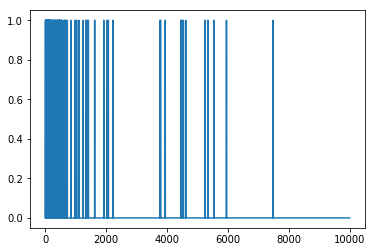

In [3]:
plt.plot(train_data[0])

## 演示过拟合
要防止过拟合，最简单的方法是缩小模型，即减少模型中可学习参数的数量（由层数和每层的单元数决定）。在深度学习中，模型中可学习参数的数量通常称为模型的“容量”。直观而言，参数越多的模型“记忆容量”越大，因此能够轻松学习训练样本与其目标之间的字典式完美映射（无任何泛化能力的映射），但如果要对之前未见过的数据做出预测，这种映射毫无用处。

请务必谨记：深度学习模型往往善于与训练数据拟合，但真正的挑战是泛化，而非拟合。

另一方面，如果网络的记忆资源有限，便无法轻松学习映射。为了最小化损失，它必须学习具有更强预测能力的压缩表示法。同时，如果模型太小，它将难以与训练数据拟合。我们需要在“太多容量”和“容量不足”这两者之间实现平衡。

遗憾的是，并没有什么神奇公式可用来确定合适的模型大小或架构（由层数或每层的合适大小决定）。您将需要尝试一系列不同的架构。

要找到合适的模型大小，最好先使用相对较少的层和参数，然后开始增加层的大小或添加新的层，直到看到返回的验证损失不断减小为止。我们在影评分类网络上试试这个方法。

我们将仅使用 Dense 层创建一个简单的基准模型，然后创建更小和更大的版本，并比较这些版本。

### 创建基准模型

In [4]:
baseline_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [5]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)


Train on 25000 samples, validate on 25000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 7s - loss: 0.4588 - acc: 0.8135 - binary_crossentropy: 0.4588 - val_loss: 0.3179 - val_acc: 0.8792 - val_binary_crossentropy: 0.3179
Epoch 2/20
 - 5s - loss: 0.2359 - acc: 0.9160 - binary_crossentropy: 0.2359 - val_loss: 0.2836 - val_acc: 0.8883 - val_binary_crossentropy: 0.2836
Epoch 3/20
 - 3s - loss: 0.1763 - acc: 0.9381 - binary_crossentropy: 0.1763 - val_loss: 0.2951 - val_acc: 0.8817 - val_binary_crossentropy: 0.2951
Epoch 4/20
 - 3s - loss: 0.1449 - acc: 0.9497 - binary_crossentropy: 0.1449 - val_loss: 0.3297 - val_acc: 0.8726 - val_binary_crossentropy: 0.3297
Epoch 5/20
 - 3s - loss: 0.1202 - acc: 0.9600 - binary_crossentropy: 0.1202 - val_loss: 0.3409 - val_acc: 0.8721 - val_binary_crossentropy: 0.3409
Epoch 6/20
 - 3s - loss: 0.1002 - acc: 0.9686 - binary_crossentropy: 0.1002 - val_loss: 0.3713 - val_acc: 0.8698 - val_binary_crossentropy: 0.3713
Epoch 7/20
 - 3s - l

### 创建一个更小的模型
我们创建一个隐藏单元更少的模型，然后与我们刚刚创建的基准模型进行比较：

In [6]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

smaller_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [7]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 3s - loss: 0.6251 - acc: 0.6193 - binary_crossentropy: 0.6251 - val_loss: 0.5671 - val_acc: 0.7861 - val_binary_crossentropy: 0.5671
Epoch 2/20
 - 3s - loss: 0.5117 - acc: 0.8186 - binary_crossentropy: 0.5117 - val_loss: 0.5038 - val_acc: 0.8389 - val_binary_crossentropy: 0.5038
Epoch 3/20
 - 3s - loss: 0.4534 - acc: 0.8795 - binary_crossentropy: 0.4534 - val_loss: 0.4735 - val_acc: 0.8644 - val_binary_crossentropy: 0.4735
Epoch 4/20
 - 3s - loss: 0.4146 - acc: 0.9096 - binary_crossentropy: 0.4146 - val_loss: 0.4555 - val_acc: 0.8748 - val_binary_crossentropy: 0.4555
Epoch 5/20
 - 3s - loss: 0.3839 - acc: 0.9284 - binary_crossentropy: 0.3839 - val_loss: 0.4448 - val_acc: 0.8758 - val_binary_crossentropy: 0.4448
Epoch 6/20
 - 3s - loss: 0.3584 - acc: 0.9430 - binary_crossentropy: 0.3584 - val_loss: 0.4457 - val_acc: 0.8687 - val_binary_crossentropy: 0.4457
Epoch 7/20
 - 3s - loss: 0.3356 - acc: 0.9536 - binary_crossentropy:

### 创建一个更大的模型
作为练习，您可以创建一个更大的模型，看看它多快开始过拟合。接下来，我们向这个基准添加一个容量大得多的网络，远远超出解决问题所需的容量：

In [8]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [9]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 14s - loss: 0.3437 - acc: 0.8525 - binary_crossentropy: 0.3437 - val_loss: 0.3043 - val_acc: 0.8751 - val_binary_crossentropy: 0.3043
Epoch 2/20
 - 14s - loss: 0.1450 - acc: 0.9476 - binary_crossentropy: 0.1450 - val_loss: 0.3304 - val_acc: 0.8710 - val_binary_crossentropy: 0.3304
Epoch 3/20
 - 14s - loss: 0.0485 - acc: 0.9860 - binary_crossentropy: 0.0485 - val_loss: 0.4559 - val_acc: 0.8677 - val_binary_crossentropy: 0.4559
Epoch 4/20
 - 14s - loss: 0.0073 - acc: 0.9986 - binary_crossentropy: 0.0073 - val_loss: 0.5966 - val_acc: 0.8678 - val_binary_crossentropy: 0.5966
Epoch 5/20
 - 14s - loss: 8.7762e-04 - acc: 1.0000 - binary_crossentropy: 8.7762e-04 - val_loss: 0.6854 - val_acc: 0.8700 - val_binary_crossentropy: 0.6854
Epoch 6/20
 - 14s - loss: 2.3386e-04 - acc: 1.0000 - binary_crossentropy: 2.3386e-04 - val_loss: 0.7284 - val_acc: 0.8701 - val_binary_crossentropy: 0.7284
Epoch 7/20
 - 14s - loss: 1.3825e-04 - acc: 1.

## 绘制训练损失和验证损失图表
实线表示训练损失，虚线表示验证损失（请谨记：验证损失越低，表示模型越好）。在此示例中，较小的网络开始过拟合的时间比基准模型晚（前者在 6 个周期之后，后者在 4 个周期之后），并且开始过拟合后，它的效果下降速度也慢得多。

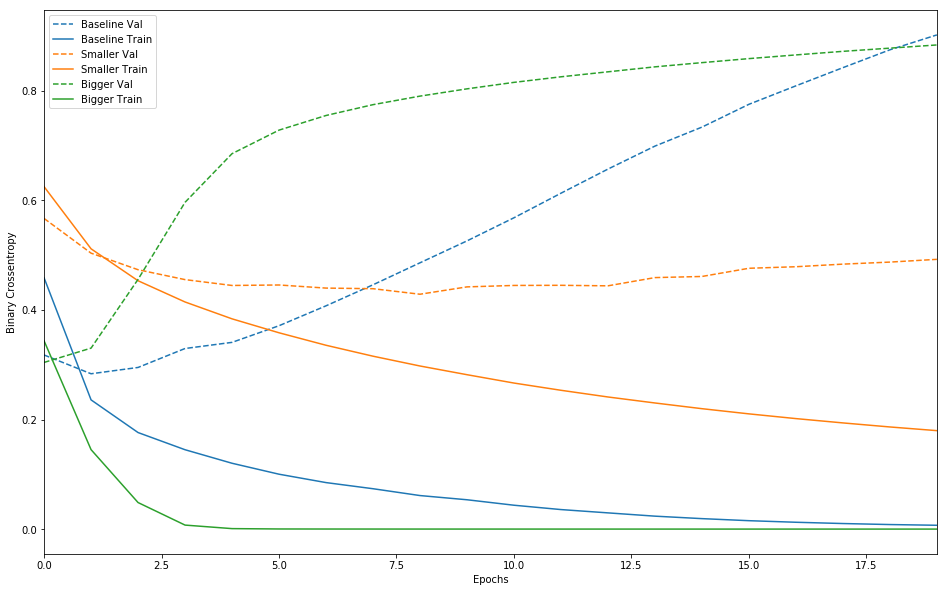

In [10]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])